In [ ]:
!pip install torch torchvision
!pip install Pillow
!pip install open3d
!pip install transformers


ERROR: Could not find a version that satisfies the requirement maplotlib (from versions: none)
ERROR: No matching distribution found for maplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found

In [ ]:
import matplotlib as plt
import torch
import numpy as np
import open3d as o3d
from PIL import Image
from transformers import DPTImageProcessor, DPTForDepthEstimation

In [ ]:
image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/490M [00:00<?, ?B/s]

In [ ]:
image = Image.open("heart.jpg")


In [ ]:
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + diff
new_size = (new_width, new_height)
image = image.resize(new_size)




In [ ]:
inputs = image_processor(images=image, return_tensors="pt")


In [ ]:

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

In [ ]:
pad= 2
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))

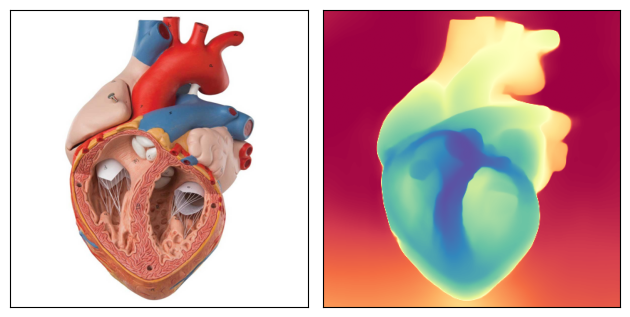

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap= 'Spectral')
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)

In [ ]:
width, height = image.size

depth_image = (output * 255 / np.max(output)).astype( 'uint8')

# Resizing depth_image to match color image dimensions
depth_image = Image.fromarray(depth_image).resize(image.size)
depth_image = np.array(depth_image)
image = np.array(image)

# create rgbd image
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

In [ ]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width / 2, height / 2)


In [ ]:
pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)


In [ ]:
# outlier removal
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd = pcd_raw.select_by_index(ind)

In [ ]:
# estimate normals

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()


In [ ]:
pcd_raw


PointCloud with 194143 points.

In [ ]:
pcd


PointCloud with 188885 points.